## Import Libraries

## Ahmed Gamal Eldeen
## Alaa Elawady
## Omar Atef ElGedawy

# **Ms Pacman**


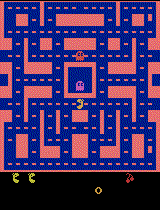

This environment is part of the https://www.gymlibrary.ml/environments/atari/. Please read that page first for general information.


Action Space Discrete(18)

Observation Space (210, 160, 3)

Observation High 255

Observation Low 0

Import gym.make("ALE/MsPacman-v5")



# Description

Your goal is to collect all of the pellets on the screen while avoiding the ghosts.

# Actions

By default, all actions that can be performed on an Atari 2600 are available in this environment. However, if you use v0 or v4 or specify full_action_space=False during initialization, only a reduced number of actions (those that are meaningful in this game) are available. The reduced action space may depend on the flavor of the environment (the combination of mode and difficulty). The reduced action space for the default flavor looks like this:


Num Action

0  NOOP

1  UP

2  RIGHT

3  LEFT

4  DOWN

5  UPRIGHT

6  UPLEFT

7  DOWNRIGHT

8  DOWNLEFT



# **Observations**

By default, the environment returns the RGB image that is displayed to human players as an observation. However, it is possible to observe

The 128 Bytes of RAM of the console

A grayscale image

instead. The respective observation spaces are

Box([0 ... 0], [255 ... 255], (128,), uint8)

Box([[0 ... 0] ... [0  ... 0]], [[255 ... 255] ... [255  ... 255]], (250, 160), uint8)

respectively. The general article on Atari environments outlines different ways to instantiate corresponding environments via gym.make.

# Arguments

env = gym.make("ALE/MsPacman-v5")
The various ways to configure the environment are described in detail in the article on Atari environments.

Environment

Valid Modes

Valid Difficulties

Default Mode

MsPacman

[0, ..., 3]

[0]

0

You may use the suffix “-ram” to switch to the RAM observation space. In v0 and v4, the suffixes “Deterministic” and “Noframeskip” are available. These are no longer supported in v5. In order to obtain equivalent behavior, pass keyword arguments to gym.make as outlined in the general article on Atari environments. The versions v0 and v4 are not contained in the “ALE” namespace. I.e. they are instantiated via gym.make("MsPacman-v0")

# Version History

A thorough discussion of the intricate differences between the versions and configurations can be found in the general article on Atari environments.

v5: Stickiness was added back and stochastic frameskipping was removed. The entire action space is used by default. The environments are now in the “ALE” namespace.

v4: Stickiness of actions was removed

v0: Initial versions release (1.0.0)

In [ ]:
import random
import numpy as np
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

## Deep Q-network

python implementation of Deep Q Networks using Keras and OpenAI gym. This program learns to play MsPacman. With very little change it could be made to learn just about any other Atari game.

The  Q-networks has 3 convolutional layers and  fully connected layers . 

The agent learns to play the MsPacman-v0 Gym environment.


## Building the DQN Agent

In [ ]:
class DQN_Agent:
    #
    # Initializes attributes and constructs CNN model and target_model
    #
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        
        # Hyperparameters
        self.gamma = 1.0            # Discount rate
        self.epsilon = 1.0          # Exploration rate
        self.epsilon_min = 0.1      # Minimal exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.update_rate = 1000     # Number of steps until updating the target network
        
        # Construct DQN models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()

    #
    # Constructs CNN
    #
    def _build_model(self):
        model = Sequential()
        
        # Conv Layers
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())

        # FC Layers
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=Adam())
        return model

    #
    # Stores experience in replay memory
    #
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    #
    # Chooses action based on epsilon-greedy policy
    #
    def act(self, state):
        # Random exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])  # Returns action using policy

    #
    # Trains the model using randomly selected experiences in the replay memory
    #
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            
            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)))
            else:
                target = reward
                
            # Construct the target vector as follows:
            # 1. Use the current model to output the Q-value predictions
            target_f = self.model.predict(state)
            
            # 2. Rewrite the chosen action value with the computed target
            target_f[0][action] = target
            
            # 3. Use vectors in the objective computation
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    #
    # Sets the target model parameters to the current model parameters
    #
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
            
    #
    # Loads a saved model
    #
    def load(self, name):
        self.model.load_weights(name)

    #
    # Saves parameters of a trained model
    #
    def save(self, name):
        self.model.save_weights(name)

## Preprocess frames of the state (Cropping and 

In [ ]:
# Helpful preprocessing taken from github.com/ageron/tiny-dqn
def process_frame(frame):
    mspacman_color = np.array([210, 164, 74]).mean()
    img = frame[1:176:2, ::2]    # Crop and downsize
    img = img.mean(axis=2)       # Convert to greyscale
    img[img==mspacman_color] = 0 # Improve contrast by making pacman white
    img = (img - 128) / 128 - 1  # Normalize from -1 to 1.
    
    return np.expand_dims(img.reshape(88, 80, 1), axis=0)

In [ ]:
def blend_images(images, blend):
    avg_image = np.expand_dims(np.zeros((88, 80, 1), np.float64), axis=0)

    for image in images:
        avg_image += image
        
    if len(images) < blend:
        return avg_image / len(images)
    else:
        return avg_image / blend

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms .

Streaming output truncated to the last 5000 lines.
Extracting  ROMS/Bank Heist (Unknown) (PAL).bin                            3%  OK 
Extracting  ROMS/Barnstorming (1982) (Activision, Steve Cartwright) (AX-013) ~.bin       3%  OK 
Extracting  ROMS/Barnstorming (CCE).bin                                    3%  OK 
Extracting  ROMS/Barnstorming (Unknown) (PAL) [a].bin                      3%  OK 
Extracting  ROMS/Barnstorming (Unknown) (PAL).bin                          3%  OK 
Extracting  ROMS/Barnstorming - Die tollkeuhnen Flieger (1982) (Activision, Steve Cartwright - Ariola) (EAX-013, PAX-013 - 711 013-720) (PAL).bin       3%  OK 
Extracting  ROMS/Base Attack (1983) (Home Vision - Gem International Corporation - VDI) (VCS83113) (PAL) ~.bin       3%  OK 
Extracting  ROMS/Base Attack (Hack) (Unknown).bin                          3%  OK 
Extracting  ROMS/Baseball (AKA Super Challenge Baseball) (1988) (Telegames) (566

In [ ]:
env = gym.make('MsPacman-v0')
state_size = (88, 80, 1)
action_size = env.action_space.n
agent = DQN_Agent(state_size, action_size)

episodes = 30
batch_size = 4
skip_start = 90  # MsPacman-v0 waits for 90 actions before the episode begins
total_time = 0   # Counter for total number of steps taken
all_rewards = 0  # Used to compute avg reward over time
blend = 4        # Number of images to blend
done = False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 20, 32)        2080      
                                                                 
 activation (Activation)     (None, 22, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 10, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 11, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 10, 64)        36928     
                                                                 
 activation_2 (Activation)   (None, 11, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 7040)              0

In [ ]:
episode_rewards = []
for e in range(episodes):
    print(f'Started episode {e+1} ......')
    total_reward = 0
    game_score = 0
    state = process_frame(env.reset())
    images = deque(maxlen=blend)  # Array of images to be blended
    images.append(state)
    
    for skip in range(skip_start): # skip the start of each game
        env.step(0)
    
    for time in range(20000):
        env.render(mode='rgb_array')
        total_time += 1
        
        # Every update_rate timesteps we update the target network parameters
        if total_time % agent.update_rate == 0:
            agent.update_target_model()
        
        # Return the avg of the last 4 frames
        state = blend_images(images, blend)
        # Transition Dynamics
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        
        # Return the avg of the last 4 frames
        next_state = process_frame(next_state)
        images.append(next_state)
        next_state = blend_images(images, blend)
        
        # Store sequence in replay memory
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        game_score += reward
        reward -= 1  # Punish behavior which does not accumulate reward
        total_reward += reward
        
        if done:
            all_rewards += game_score
            episode_rewards.append(all_rewards)
            
            print("episode: {}/{}, game score: {}, reward: {}, avg reward: {}, std: {},time:{}, total time: {}"
                  .format(e+1, episodes, game_score, total_reward, np.mean(episode_rewards), np.std(episode_rewards), time, total_time))
            break
            
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

Started episode 1 ......
episode: 1/30, game score: 880.0, reward: 153.0, avg reward: 880.0, std: 0.0,time:726, total time: 727
Started episode 2 ......
episode: 2/30, game score: 220.0, reward: -472.0, avg reward: 990.0, std: 110.0,time:691, total time: 1419
Started episode 3 ......
episode: 3/30, game score: 310.0, reward: -259.0, avg reward: 1130.0, std: 217.40898478827103,time:568, total time: 1988
Started episode 4 ......
episode: 4/30, game score: 430.0, reward: -163.0, avg reward: 1307.5, std: 360.5117889889317,time:592, total time: 2581
Started episode 5 ......
episode: 5/30, game score: 410.0, reward: -616.0, avg reward: 1496.0, std: 496.088701745968,time:1025, total time: 3607
Started episode 6 ......
episode: 6/30, game score: 280.0, reward: -221.0, avg reward: 1668.3333333333333, std: 594.6263999820018,time:500, total time: 4108
Started episode 7 ......
episode: 7/30, game score: 1230.0, reward: 420.0, avg reward: 1967.142857142857, std: 915.8557947268192,time:809, total ti

In [ ]:
agent.save('models/model_30')

In [2]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
env.reset()

for i in range(1000):
  env.render(mode='rgb_array')
  video.capture_frame()
  # env.action_space.sample() produces either 0 (left) or 1 (right).
  observation, reward, done, info = env.step(env.action_space.sample())
  # Not printing this time
  #print("step", i, observation, reward, done, info)

video.close()
env.close()

In [ ]:
env.action_space

In [ ]:
from gym.wrappers import RecordVideo

In [ ]:
after_training = "after_training.mp4"

In [ ]:
new_obs

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

after_training = "after_training.mp4"
video = VideoRecorder(env, after_training)

# returns an initial observation

new_env = gym.make('MsPacman-v0')
new_obs = env.reset()

while True:
  env.render(mode='rgb_array')
  video.capture_frame()

  state = process_frame(new_obs)
  action = agent.act(state)
  obs, reward, done, _ = env.step(action)

  if done:
    break

video.close()
env.close()

In [3]:
from IPython.display import HTML
html = render_mp4('/content/trained.mp4')
HTML(html)